<a href="https://colab.research.google.com/github/mshilpaa/EVA4/blob/master/Session%206/l1_%3D_0_00005_l2_%3D_0_005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


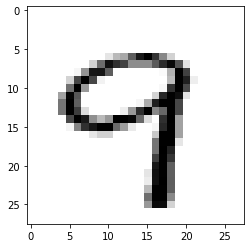

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

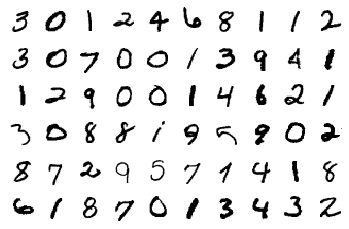

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), # i/p= 28 o/p=26 r=3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # i/p=26  o/p=24 r=5
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(p=0.05),
            
            nn.MaxPool2d(kernel_size=(2,2)), # i/p=24  o/p=12 r=6  

            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=12  o/p=10 r=10
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),
            

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=10  o/p=8 r=14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=8  o/p=6 r=18
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=6  o/p=4 r=22
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=4  o/p=2 r=26
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.AdaptiveAvgPool2d(1),

            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),


        ) 

    def forward(self, x):

        x = self.convblock1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]           1,080
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
def L1_loss(model, data, factor):
  l1_crit = nn.L1Loss().to(device)
  reg_loss = 0
  for param in model.parameters():
    zero_vector = torch.rand_like(param) * 0
    reg_loss += l1_crit(param, zero_vector)
  return factor * reg_loss

In [0]:
def misclassified_images(misclassify):
  j=0
  fig = plt.figure(figsize=(15,15)) 
  for i in range(25): 
      ax = fig.add_subplot(5,5 , 1 + j) # 4 rows, 3 columns, 1+j is the index which gives position of each image in the plot
      plt.imshow(misclassify[i][0].cpu().numpy().squeeze(), cmap='gray_r') # display the image
      title = "Predicted: "+ str(misclassify[i][1][0].data.cpu().numpy())+" Target: "+ str(misclassify[i][2].data.cpu().numpy())
      ax.set_title(title) # give the class of the image as its title
      j+=1
  plt.subplots_adjust( hspace=0.5, wspace=0.35)      
  plt.show()

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassify = []

def train(model, device, train_loader, optimizer, epoch, use_l1 = False,l1_factor = 0.0005):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    if use_l1 == True:
      loss += L1_loss(model,data,factor=l1_factor)

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # output is the probability for each class
            # output look like this: [[10 values(classes)],[],... 16(batch size) lists]
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            for i in range(len(pred)):
              if pred[i] != target[i]:
                misclassify.append([data[i],pred[i],target[i]])
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    # print("o === ",pred,"-------target = ",target,"output",output.shape)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # print(len(misclassify))
    # print(misclassify[0][0].size()) 
    test_acc.append(100. * correct / len(test_loader.dataset))

    # j=0
    # fig = plt.figure(figsize=(15,15)) 
    # for i in range(25): 
    #     ax = fig.add_subplot(7,4 , 1 + j) # 4 rows, 3 columns, 1+j is the index which gives position of each image in the plot
    #     plt.imshow(misclassify[i][0].cpu().numpy().squeeze(), cmap='gray_r') # display the image
    #     title = "predicted: "+ str(misclassify[i][1].data.cpu().numpy())+"target: "+ str(misclassify[i][2].data.cpu().numpy())
    #     ax.set_title(title) # give the class of the image as its title
    #     j+=1      
    # plt.show()

# Let's Train and test our model

In [12]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.13253428041934967 Batch_id=468 Accuracy=91.44: 100%|██████████| 469/469 [00:11<00:00, 39.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0623, Accuracy: 9819/10000 (98.19%)

EPOCH: 1 lr =  0.01


Loss=0.14702953398227692 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:12<00:00, 38.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9882/10000 (98.82%)

EPOCH: 2 lr =  0.01


Loss=0.044326771050691605 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:12<00:00, 38.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9897/10000 (98.97%)

EPOCH: 3 lr =  0.01


Loss=0.032509077340364456 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:11<00:00, 39.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9896/10000 (98.96%)

EPOCH: 4 lr =  0.01


Loss=0.026553237810730934 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:11<00:00, 39.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9903/10000 (99.03%)

EPOCH: 5 lr =  0.01


Loss=0.01655547320842743 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:12<00:00, 37.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9924/10000 (99.24%)

EPOCH: 6 lr =  0.001


Loss=0.02521613799035549 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 48.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

EPOCH: 7 lr =  0.001


Loss=0.006138990167528391 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 39.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

EPOCH: 8 lr =  0.0001


Loss=0.004867419600486755 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 39.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH: 9 lr =  0.0001


Loss=0.003445262787863612 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 37.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 10 lr =  0.0001


Loss=0.06680389493703842 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 37.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)

EPOCH: 11 lr =  0.0001


Loss=0.011381496675312519 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 38.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9931/10000 (99.31%)

EPOCH: 12 lr =  1e-05


Loss=0.08604822307825089 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 38.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9933/10000 (99.33%)

EPOCH: 13 lr =  1e-05


Loss=0.004509106278419495 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 44.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 14 lr =  1e-05


Loss=0.006783594843000174 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 38.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99.36%)

EPOCH: 15 lr =  1e-05


Loss=0.006906077265739441 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 38.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH: 16 lr =  1e-05


Loss=0.0580684132874012 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:12<00:00, 38.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

EPOCH: 17 lr =  1e-05


Loss=0.008854825980961323 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 18 lr =  1e-05


Loss=0.030304908752441406 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:12<00:00, 38.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

EPOCH: 19 lr =  1e-05


Loss=0.04898640140891075 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

EPOCH: 20 lr =  1e-05


Loss=0.0223980899900198 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 39.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

EPOCH: 21 lr =  1e-05


Loss=0.013111263513565063 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 39.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 22 lr =  1e-05


Loss=0.05711790919303894 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:12<00:00, 37.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 23 lr =  1e-05


Loss=0.0153787387534976 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 38.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9934/10000 (99.34%)

EPOCH: 24 lr =  1e-05


Loss=0.04189685359597206 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 39.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 25 lr =  1e-05


Loss=0.025100642815232277 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

EPOCH: 26 lr =  1e-05


Loss=0.04899875447154045 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 37.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)

EPOCH: 27 lr =  1e-05


Loss=0.06586185097694397 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 37.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9935/10000 (99.35%)

EPOCH: 28 lr =  1e-05


Loss=0.01261204481124878 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 37.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH: 29 lr =  1e-05


Loss=0.011076107621192932 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 37.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)

EPOCH: 30 lr =  1e-05


Loss=0.0723012164235115 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 35.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9940/10000 (99.40%)

EPOCH: 31 lr =  1e-05


Loss=0.020834961906075478 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 36.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 32 lr =  1e-05


Loss=0.02237442135810852 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 45.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9938/10000 (99.38%)

EPOCH: 33 lr =  1e-05


Loss=0.004070892930030823 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 36.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH: 34 lr =  1e-05


Loss=0.0029763083439320326 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 34.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH: 35 lr =  1e-05


Loss=0.0031648229341953993 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 36.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 36 lr =  1e-05


Loss=0.031124627217650414 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 36.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.36%)

EPOCH: 37 lr =  1e-05


Loss=0.024371108040213585 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 36.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)

EPOCH: 38 lr =  1e-05


Loss=0.009968633763492107 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 43.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)

EPOCH: 39 lr =  1e-05


Loss=0.009545296430587769 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 35.76it/s]



Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)



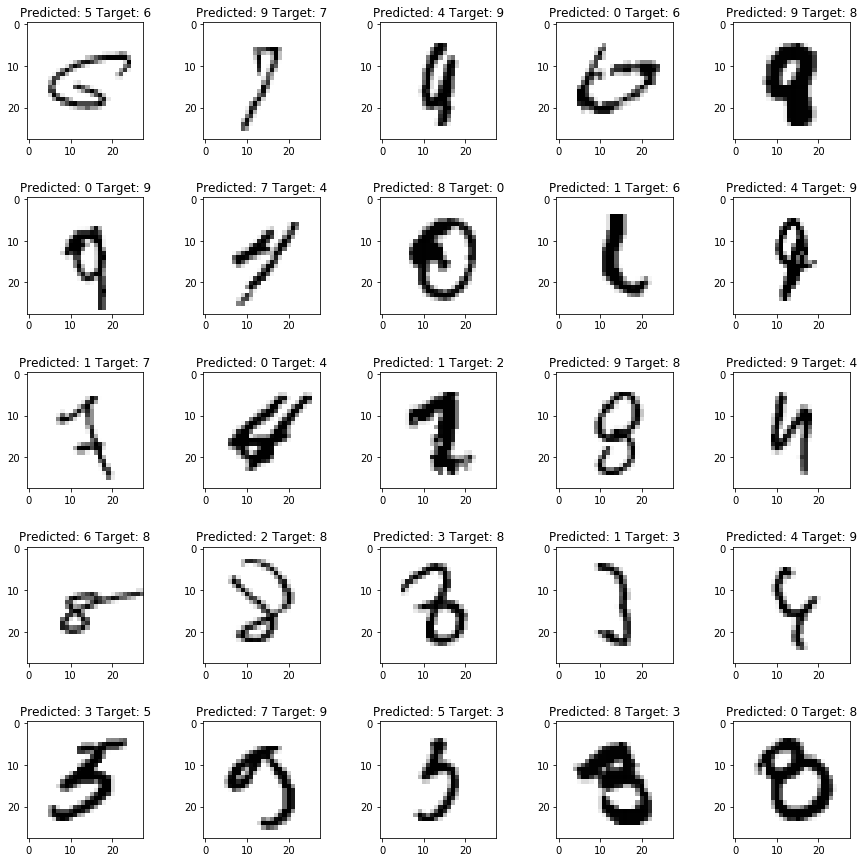

In [13]:
misclassified_images(misclassify)

In [0]:
train_acc_without_l1_l2 = train_acc.copy()
train_loss_without_l1_l2 = train_losses.copy()
test_acc_without_l1_l2 = test_acc.copy()
test_loss_without_l1_l2 = test_losses.copy()


Text(0.5, 1.0, 'Test Accuracy')

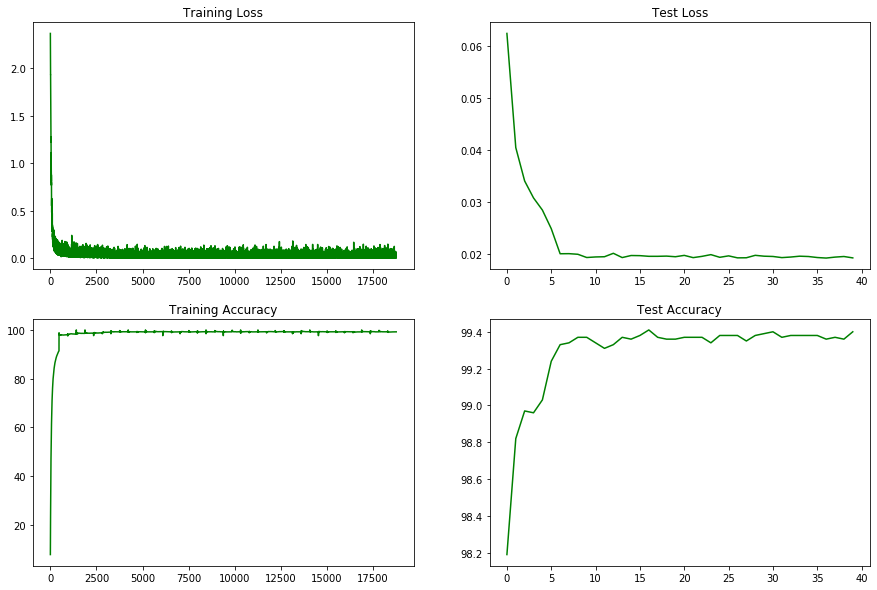

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_without_l1_l2,color = 'g')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_without_l1_l2,color = 'g')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_loss_without_l1_l2,color = 'g')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_without_l1_l2,color = 'g')
axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L1**

In [17]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch,use_l1 = True,l1_factor=0.00005)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.07446973025798798 Batch_id=468 Accuracy=91.55: 100%|██████████| 469/469 [00:15<00:00, 30.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 9832/10000 (98.32%)

EPOCH: 1 lr =  0.01


Loss=0.06181711331009865 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:14<00:00, 31.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9860/10000 (98.60%)

EPOCH: 2 lr =  0.01


Loss=0.08032030612230301 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9883/10000 (98.83%)

EPOCH: 3 lr =  0.01


Loss=0.007542060222476721 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9895/10000 (98.95%)

EPOCH: 4 lr =  0.01


Loss=0.027685323730111122 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9901/10000 (99.01%)

EPOCH: 5 lr =  0.01


Loss=0.08392305672168732 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9916/10000 (99.16%)

EPOCH: 6 lr =  0.001


Loss=0.0807756558060646 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

EPOCH: 7 lr =  0.001


Loss=0.017289655283093452 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9924/10000 (99.24%)

EPOCH: 8 lr =  0.0001


Loss=0.06723108142614365 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9925/10000 (99.25%)

EPOCH: 9 lr =  0.0001


Loss=0.006383120082318783 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9923/10000 (99.23%)

EPOCH: 10 lr =  0.0001


Loss=0.004665915388613939 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 33.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9925/10000 (99.25%)

EPOCH: 11 lr =  0.0001


Loss=0.09672657400369644 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9929/10000 (99.29%)

EPOCH: 12 lr =  1e-05


Loss=0.03836943209171295 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 31.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9927/10000 (99.27%)

EPOCH: 13 lr =  1e-05


Loss=0.014545932412147522 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)

EPOCH: 14 lr =  1e-05


Loss=0.006395173259079456 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9926/10000 (99.26%)

EPOCH: 15 lr =  1e-05


Loss=0.0714983120560646 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9927/10000 (99.27%)

EPOCH: 16 lr =  1e-05


Loss=0.0066804601810872555 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9934/10000 (99.34%)

EPOCH: 17 lr =  1e-05


Loss=0.006261764094233513 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 18 lr =  1e-05


Loss=0.06011708080768585 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9930/10000 (99.30%)

EPOCH: 19 lr =  1e-05


Loss=0.05433379486203194 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 40.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

EPOCH: 20 lr =  1e-05


Loss=0.027812862768769264 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

EPOCH: 21 lr =  1e-05


Loss=0.0019350899383425713 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9928/10000 (99.28%)

EPOCH: 22 lr =  1e-05


Loss=0.0075666774064302444 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9930/10000 (99.30%)

EPOCH: 23 lr =  1e-05


Loss=0.07151570916175842 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9933/10000 (99.33%)

EPOCH: 24 lr =  1e-05


Loss=0.010973797179758549 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)

EPOCH: 25 lr =  1e-05


Loss=0.012039048597216606 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9927/10000 (99.27%)

EPOCH: 26 lr =  1e-05


Loss=0.018497178331017494 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9926/10000 (99.26%)

EPOCH: 27 lr =  1e-05


Loss=0.037480682134628296 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH: 28 lr =  1e-05


Loss=0.011527313850820065 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)

EPOCH: 29 lr =  1e-05


Loss=0.03921476751565933 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

EPOCH: 30 lr =  1e-05


Loss=0.051847465336322784 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 31.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9927/10000 (99.27%)

EPOCH: 31 lr =  1e-05


Loss=0.06812135875225067 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9929/10000 (99.29%)

EPOCH: 32 lr =  1e-05


Loss=0.014958631247282028 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9929/10000 (99.29%)

EPOCH: 33 lr =  1e-05


Loss=0.03496084362268448 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 31.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

EPOCH: 34 lr =  1e-05


Loss=0.013422656804323196 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 31.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9928/10000 (99.28%)

EPOCH: 35 lr =  1e-05


Loss=0.028373273089528084 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 40.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

EPOCH: 36 lr =  1e-05


Loss=0.0030167580116540194 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9927/10000 (99.27%)

EPOCH: 37 lr =  1e-05


Loss=0.0192527174949646 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

EPOCH: 38 lr =  1e-05


Loss=0.04334310069680214 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9926/10000 (99.26%)

EPOCH: 39 lr =  1e-05


Loss=0.005381190218031406 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 38.32it/s]



Test set: Average loss: 0.0217, Accuracy: 9929/10000 (99.29%)



In [18]:
len(misclassify)

71

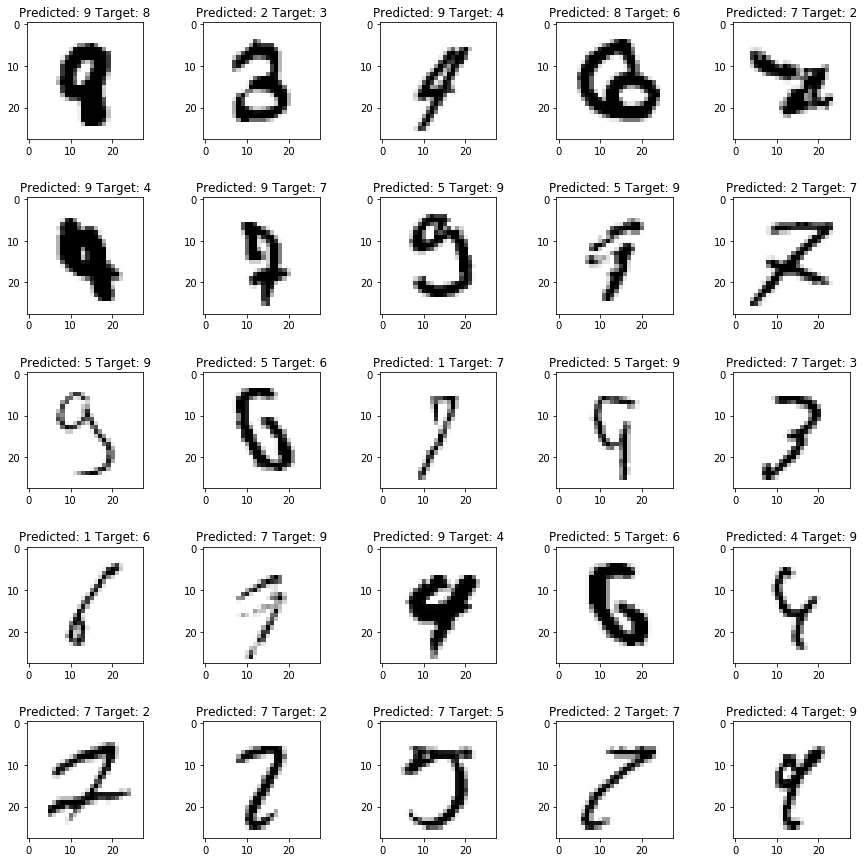

In [19]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l1 = train_acc.copy()
train_loss_with_l1 = train_losses.copy()
test_acc_with_l1 = test_acc.copy()
test_loss_with_l1 = test_losses.copy()

Text(0.5, 1.0, 'Test Accuracy')

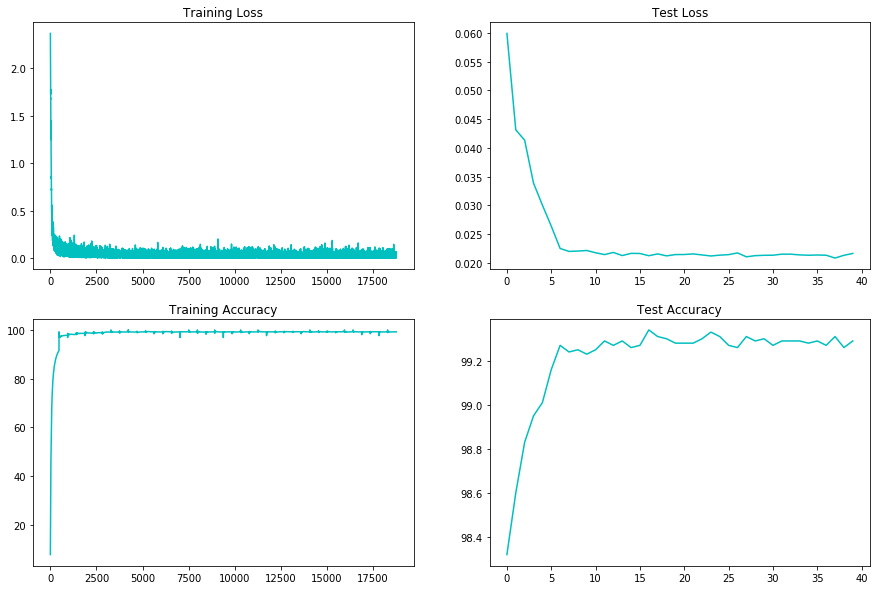

In [21]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_with_l1,color='c')
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l1,color='c')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l1,color='c')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l1,color='c')

axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L2**

In [23]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.005)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.16891521215438843 Batch_id=468 Accuracy=90.15: 100%|██████████| 469/469 [00:12<00:00, 42.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0777, Accuracy: 9792/10000 (97.92%)

EPOCH: 1 lr =  0.01


Loss=0.12642468512058258 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:12<00:00, 36.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0758, Accuracy: 9804/10000 (98.04%)

EPOCH: 2 lr =  0.01


Loss=0.11499466747045517 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:12<00:00, 37.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9885/10000 (98.85%)

EPOCH: 3 lr =  0.01


Loss=0.043832480907440186 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:12<00:00, 37.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9886/10000 (98.86%)

EPOCH: 4 lr =  0.01


Loss=0.09348922967910767 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:12<00:00, 36.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9900/10000 (99.00%)

EPOCH: 5 lr =  0.01


Loss=0.08333248645067215 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:12<00:00, 36.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9889/10000 (98.89%)

EPOCH: 6 lr =  0.001


Loss=0.02566632069647312 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:12<00:00, 37.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9927/10000 (99.27%)

EPOCH: 7 lr =  0.001


Loss=0.02805652655661106 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 37.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9933/10000 (99.33%)

EPOCH: 8 lr =  0.0001


Loss=0.02435935288667679 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:12<00:00, 37.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9935/10000 (99.35%)

EPOCH: 9 lr =  0.0001


Loss=0.06286788731813431 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 37.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9935/10000 (99.35%)

EPOCH: 10 lr =  0.0001


Loss=0.023776913061738014 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:12<00:00, 38.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9937/10000 (99.37%)

EPOCH: 11 lr =  0.0001


Loss=0.07825852185487747 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 38.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9936/10000 (99.36%)

EPOCH: 12 lr =  1e-05


Loss=0.027069324627518654 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 37.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9935/10000 (99.35%)

EPOCH: 13 lr =  1e-05


Loss=0.021880611777305603 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:12<00:00, 36.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9934/10000 (99.34%)

EPOCH: 14 lr =  1e-05


Loss=0.028871221467852592 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 31.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9935/10000 (99.35%)

EPOCH: 15 lr =  1e-05


Loss=0.0465267039835453 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 36.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9936/10000 (99.36%)

EPOCH: 16 lr =  1e-05


Loss=0.06661060452461243 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9936/10000 (99.36%)

EPOCH: 17 lr =  1e-05


Loss=0.033972952514886856 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 34.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9936/10000 (99.36%)

EPOCH: 18 lr =  1e-05


Loss=0.0660412535071373 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 35.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9937/10000 (99.37%)

EPOCH: 19 lr =  1e-05


Loss=0.02489876002073288 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 34.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9936/10000 (99.36%)

EPOCH: 20 lr =  1e-05


Loss=0.0394904650747776 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 42.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9937/10000 (99.37%)

EPOCH: 21 lr =  1e-05


Loss=0.024594483897089958 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9935/10000 (99.35%)

EPOCH: 22 lr =  1e-05


Loss=0.015982454642653465 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:12<00:00, 36.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9936/10000 (99.36%)

EPOCH: 23 lr =  1e-05


Loss=0.042814094573259354 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 38.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9937/10000 (99.37%)

EPOCH: 24 lr =  1e-05


Loss=0.04255199804902077 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 36.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9939/10000 (99.39%)

EPOCH: 25 lr =  1e-05


Loss=0.056658368557691574 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:12<00:00, 37.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9937/10000 (99.37%)

EPOCH: 26 lr =  1e-05


Loss=0.021626004949212074 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 38.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9935/10000 (99.35%)

EPOCH: 27 lr =  1e-05


Loss=0.05057661607861519 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 38.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9936/10000 (99.36%)

EPOCH: 28 lr =  1e-05


Loss=0.02751481719315052 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 36.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9938/10000 (99.38%)

EPOCH: 29 lr =  1e-05


Loss=0.0416141115128994 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 37.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9936/10000 (99.36%)

EPOCH: 30 lr =  1e-05


Loss=0.05692783370614052 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 28.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9940/10000 (99.40%)

EPOCH: 31 lr =  1e-05


Loss=0.026086067780852318 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9937/10000 (99.37%)

EPOCH: 32 lr =  1e-05


Loss=0.06800301373004913 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 33.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9938/10000 (99.38%)

EPOCH: 33 lr =  1e-05


Loss=0.0234072282910347 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9938/10000 (99.38%)

EPOCH: 34 lr =  1e-05


Loss=0.12155866622924805 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 35.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9937/10000 (99.37%)

EPOCH: 35 lr =  1e-05


Loss=0.03540406748652458 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 35.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9938/10000 (99.38%)

EPOCH: 36 lr =  1e-05


Loss=0.056863460689783096 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 34.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9935/10000 (99.35%)

EPOCH: 37 lr =  1e-05


Loss=0.10828302055597305 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9938/10000 (99.38%)

EPOCH: 38 lr =  1e-05


Loss=0.023985132575035095 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9936/10000 (99.36%)

EPOCH: 39 lr =  1e-05


Loss=0.030692553147673607 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]



Test set: Average loss: 0.0300, Accuracy: 9938/10000 (99.38%)



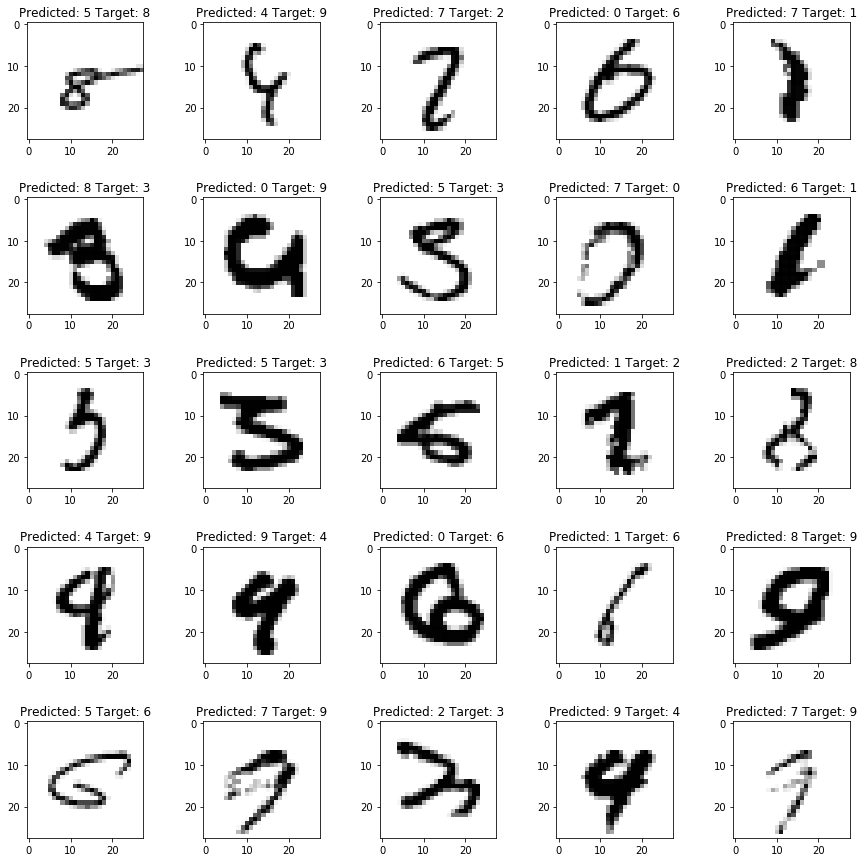

In [24]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l2 = train_acc.copy()
train_loss_with_l2 = train_losses.copy()
test_acc_with_l2 = test_acc.copy()
test_loss_with_l2 = test_losses.copy()


Text(0.5, 1.0, 'Test Accuracy')

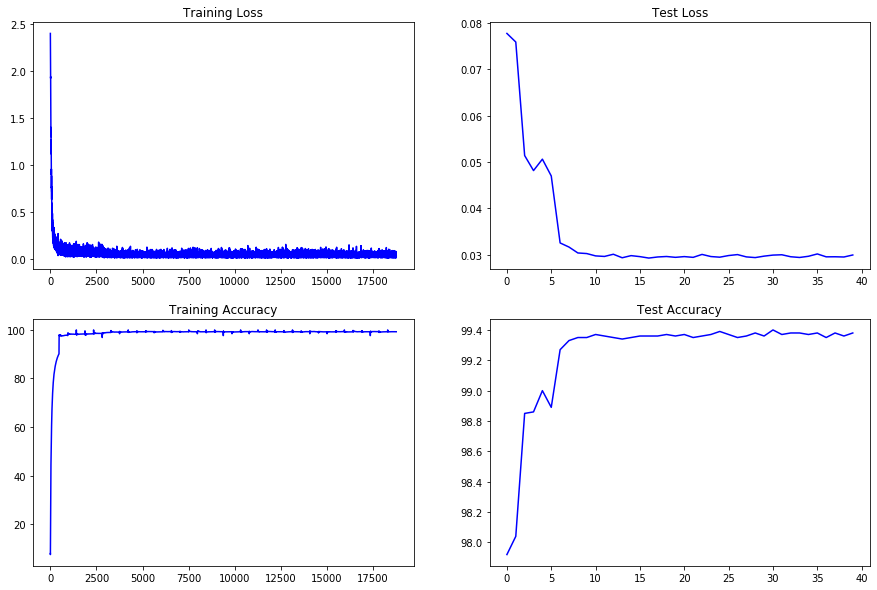

In [26]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_loss_with_l2,color = 'b')

axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l2,color = 'b')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l2,color = 'b')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l2,color = 'b')

axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L1 and L2**

In [28]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.005)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch, use_l1 = True,l1_factor=0.00005)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.07607818394899368 Batch_id=468 Accuracy=91.29: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0745, Accuracy: 9821/10000 (98.21%)

EPOCH: 1 lr =  0.01


Loss=0.045603327453136444 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0604, Accuracy: 9849/10000 (98.49%)

EPOCH: 2 lr =  0.01


Loss=0.04491415619850159 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9889/10000 (98.89%)

EPOCH: 3 lr =  0.01


Loss=0.023180251941084862 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9891/10000 (98.91%)

EPOCH: 4 lr =  0.01


Loss=0.048666585236787796 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9864/10000 (98.64%)

EPOCH: 5 lr =  0.01


Loss=0.07486115396022797 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9885/10000 (98.85%)

EPOCH: 6 lr =  0.001


Loss=0.03265385702252388 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9933/10000 (99.33%)

EPOCH: 7 lr =  0.001


Loss=0.08259459584951401 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 38.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9933/10000 (99.33%)

EPOCH: 8 lr =  0.0001


Loss=0.036708731204271317 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9937/10000 (99.37%)

EPOCH: 9 lr =  0.0001


Loss=0.033612210303545 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9936/10000 (99.36%)

EPOCH: 10 lr =  0.0001


Loss=0.047966036945581436 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 36.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9936/10000 (99.36%)

EPOCH: 11 lr =  0.0001


Loss=0.025989731773734093 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9940/10000 (99.40%)

EPOCH: 12 lr =  1e-05


Loss=0.03406790271401405 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:14<00:00, 39.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9940/10000 (99.40%)

EPOCH: 13 lr =  1e-05


Loss=0.05634226277470589 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9941/10000 (99.41%)

EPOCH: 14 lr =  1e-05


Loss=0.05942177399992943 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9939/10000 (99.39%)

EPOCH: 15 lr =  1e-05


Loss=0.03520672023296356 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9939/10000 (99.39%)

EPOCH: 16 lr =  1e-05


Loss=0.026600399985909462 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:16<00:00, 34.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9940/10000 (99.40%)

EPOCH: 17 lr =  1e-05


Loss=0.03475558012723923 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9939/10000 (99.39%)

EPOCH: 18 lr =  1e-05


Loss=0.04709349572658539 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9939/10000 (99.39%)

EPOCH: 19 lr =  1e-05


Loss=0.078032948076725 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9936/10000 (99.36%)

EPOCH: 20 lr =  1e-05


Loss=0.03914913162589073 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:16<00:00, 28.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9940/10000 (99.40%)

EPOCH: 21 lr =  1e-05


Loss=0.04265599697828293 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 29.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9940/10000 (99.40%)

EPOCH: 22 lr =  1e-05


Loss=0.02024204283952713 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9938/10000 (99.38%)

EPOCH: 23 lr =  1e-05


Loss=0.03635365888476372 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9939/10000 (99.39%)

EPOCH: 24 lr =  1e-05


Loss=0.05671757087111473 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 37.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9938/10000 (99.38%)

EPOCH: 25 lr =  1e-05


Loss=0.051897790282964706 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9935/10000 (99.35%)

EPOCH: 26 lr =  1e-05


Loss=0.030615361407399178 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9938/10000 (99.38%)

EPOCH: 27 lr =  1e-05


Loss=0.03174367919564247 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9938/10000 (99.38%)

EPOCH: 28 lr =  1e-05


Loss=0.026702139526605606 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9939/10000 (99.39%)

EPOCH: 29 lr =  1e-05


Loss=0.11964753270149231 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9937/10000 (99.37%)

EPOCH: 30 lr =  1e-05


Loss=0.08049068599939346 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 30.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9941/10000 (99.41%)

EPOCH: 31 lr =  1e-05


Loss=0.029179221019148827 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9938/10000 (99.38%)

EPOCH: 32 lr =  1e-05


Loss=0.036934707313776016 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9935/10000 (99.35%)

EPOCH: 33 lr =  1e-05


Loss=0.04614467918872833 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9940/10000 (99.40%)

EPOCH: 34 lr =  1e-05


Loss=0.03590630739927292 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:15<00:00, 30.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9938/10000 (99.38%)

EPOCH: 35 lr =  1e-05


Loss=0.05552288889884949 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 38.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9937/10000 (99.37%)

EPOCH: 36 lr =  1e-05


Loss=0.027041437104344368 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9935/10000 (99.35%)

EPOCH: 37 lr =  1e-05


Loss=0.0185188390314579 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9940/10000 (99.40%)

EPOCH: 38 lr =  1e-05


Loss=0.030172668397426605 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9938/10000 (99.38%)

EPOCH: 39 lr =  1e-05


Loss=0.02574017085134983 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]



Test set: Average loss: 0.0310, Accuracy: 9936/10000 (99.36%)



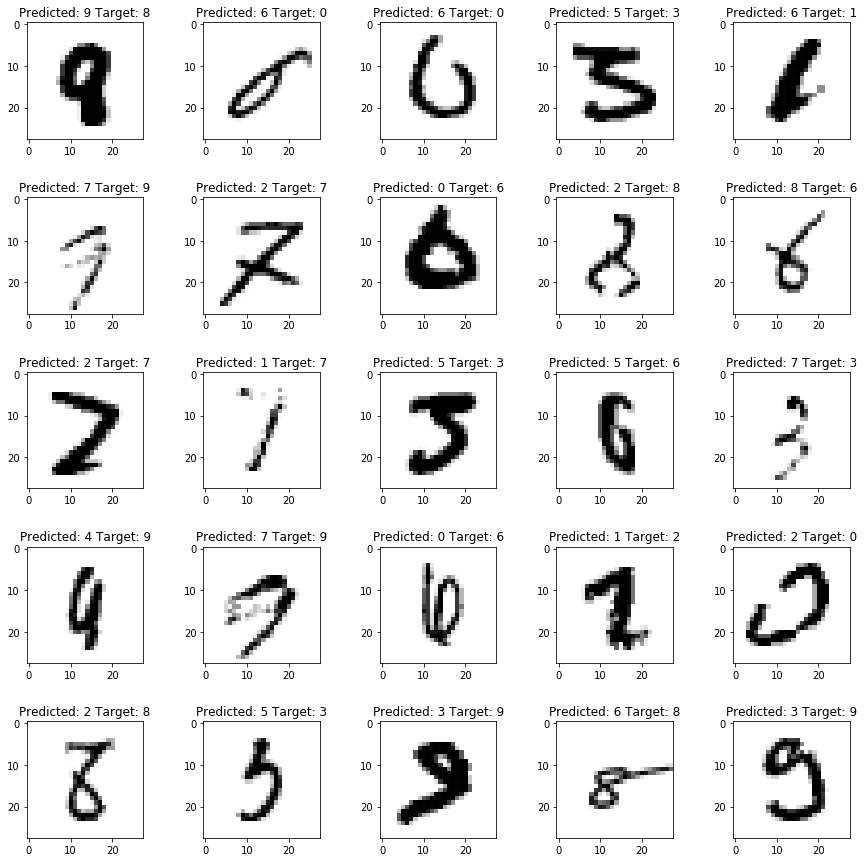

In [29]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l1_l2 = train_acc.copy()
train_loss_with_l1_l2 = train_losses.copy()
test_acc_with_l1_l2 = test_acc.copy()
test_loss_with_l1_l2 = test_losses.copy()

In [31]:
max(train_acc_with_l1_l2)

100.0

Text(0.5, 1.0, 'Test Accuracy')

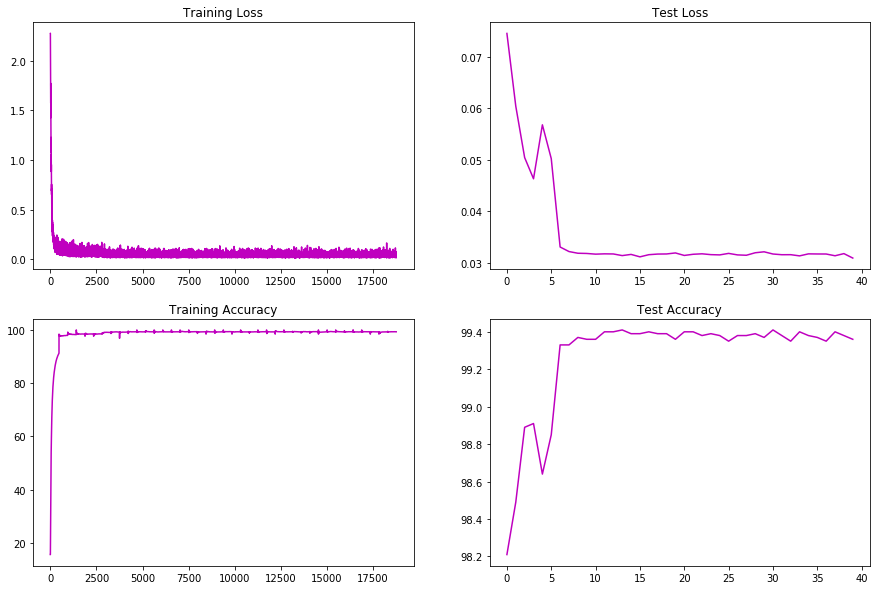

In [32]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_loss_with_l1_l2,color = 'm')

axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l1_l2,color = 'm')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l1_l2,color = 'm')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l1_l2,color = 'm')

axs[1, 1].set_title("Test Accuracy")

Text(0.5, 0.98, 'l1 = 0.00005, l2 = 0.005')

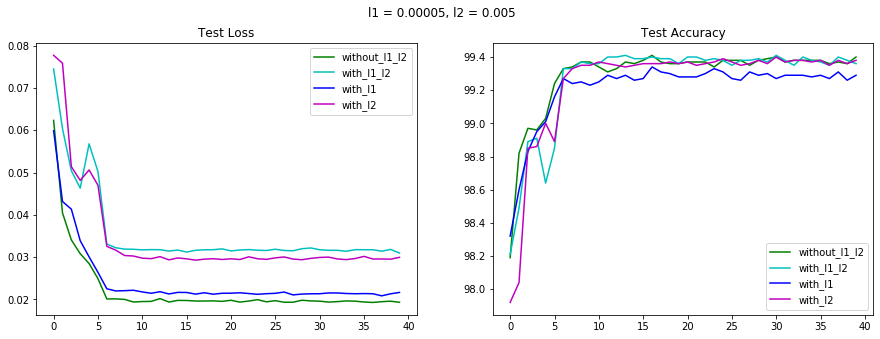

In [33]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(test_loss_without_l1_l2,color = 'g',label="without_l1_l2")
axs[0].plot(test_loss_with_l1_l2,color = 'c',label="with_l1_l2")
axs[0].plot(test_loss_with_l1,color = 'b',label="with_l1")
axs[0].plot(test_loss_with_l2,color = 'm',label="with_l2")
axs[0].set_title("Test Loss")
axs[0].legend()
axs[1].plot(test_acc_without_l1_l2,color = 'g',label="without_l1_l2")
axs[1].plot(test_acc_with_l1_l2,color = 'c',label="with_l1_l2")
axs[1].plot(test_acc_with_l1,color = 'b',label="with_l1")
axs[1].plot(test_acc_with_l2,color = 'm',label="with_l2")
axs[1].set_title("Test Accuracy")
axs[1].legend()
fig.suptitle("l1 = 0.00005, l2 = 0.005")